In [1]:
!pip install pymorphy2 category_encoders fasttext

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 48.5 MB/s eta 0:00:0000:0100:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=5cf713d99324b48ff8563cd5471f7f241d44f6cf025484230dee9c6ccb2ccfea
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import pymorphy2
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
import fasttext
from sklearn.linear_model import LogisticRegression
from category_encoders import TargetEncoder
import warnings

warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-2025-spring-porn-detection/sample_submission.csv
/kaggle/input/ml-2025-spring-porn-detection/train.csv
/kaggle/input/ml-2025-spring-porn-detection/test.csv


In [3]:
data = pd.read_csv('/kaggle/input/ml-2025-spring-porn-detection/train.csv')
data.head()

,ID,url,title,label
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


# Первый взгляд на данные

In [4]:
data.isnull().sum()

ID       0
url      0
title    1
label    0
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
data['ID'].duplicated().any() 

False

In [7]:
data.drop('ID', axis=1, inplace=True)

In [8]:
data.dtypes

url      object
title    object
label     int64
dtype: object

In [9]:
data = data.drop_duplicates(subset=['title'])

In [10]:
data = data.reset_index(drop=True)

# Target

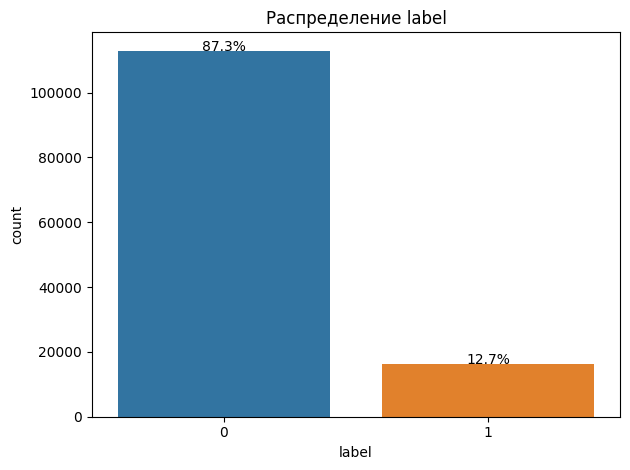

In [11]:
ax = sns.countplot(data=data, x='label')

total = len(data)
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center')
    
plt.title('Распределение label')
plt.tight_layout()
plt.show()


## URL

In [12]:
porn_urls = data[data['label']==1]['url'].nunique()

In [13]:
print(f"{porn_urls / data['url'].nunique() * 100:.1f}% url содержат порно")

8.7% url содержат порно


### Самые частые URL:

In [14]:
data['url'].value_counts()[:20]

url
mail.ru                7156
baza.drom.ru           1031
www.olx.ua              940
irecommend.ru           766
daftsex.com             716
biqle.ru                657
youla.ru                653
fotostrana.ru           607
zaycev.net              599
manga-online.biz        594
infourok.ru             566
www.farpost.ru          565
m.babyblog.ru           555
v-s.mobi                515
libking.ru              509
www.mamba.ru            462
www.liveinternet.ru     397
prom.ua                 396
cyberleninka.ru         371
pikabu.ru               365
Name: count, dtype: int64

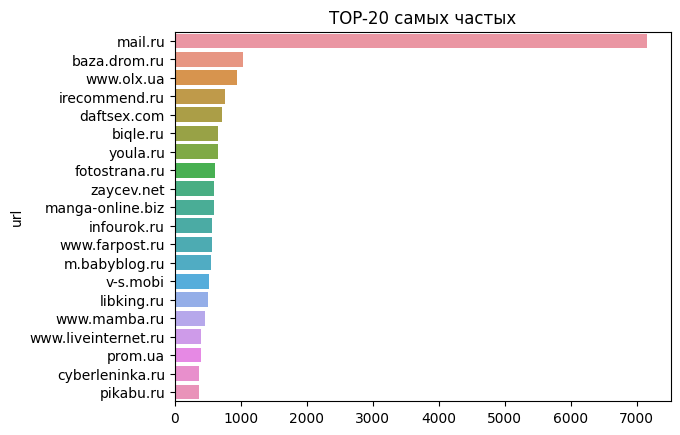

In [15]:
top_urls = data['url'].value_counts().nlargest(20)
sns.barplot(x=top_urls.values, y=top_urls.index)
plt.title('TOP-20 самых частых')
plt.show()

### Самый большой процент порно

In [16]:
# Фильтрация по минимальной встречаемости
COUNT_THRESHOLD = 30
url_counts = data['url'].value_counts()
frequent_urls = url_counts[url_counts > COUNT_THRESHOLD].index
filtered_data = data[data['url'].isin(frequent_urls)]

In [17]:
# Доля порно >=60% - порно сайт
PORN_THRESHOLD = 0.6
porn_percent = data.groupby('url')['label'].mean()
filtered_data.groupby('url')['label'].mean()[porn_percent >= PORN_THRESHOLD].sort_values(ascending=False)

url
24eropiks.com        1.000000
rusvidos.com         1.000000
rusporn.cc           1.000000
ruero.net            1.000000
regionyonsport.ch    1.000000
                       ...   
hotfiesta.tv         0.894737
uniondht.org         0.880435
erkiss.live          0.851852
gay0day.com          0.750000
www.sosalkino.tv     0.622951
Name: label, Length: 81, dtype: float64

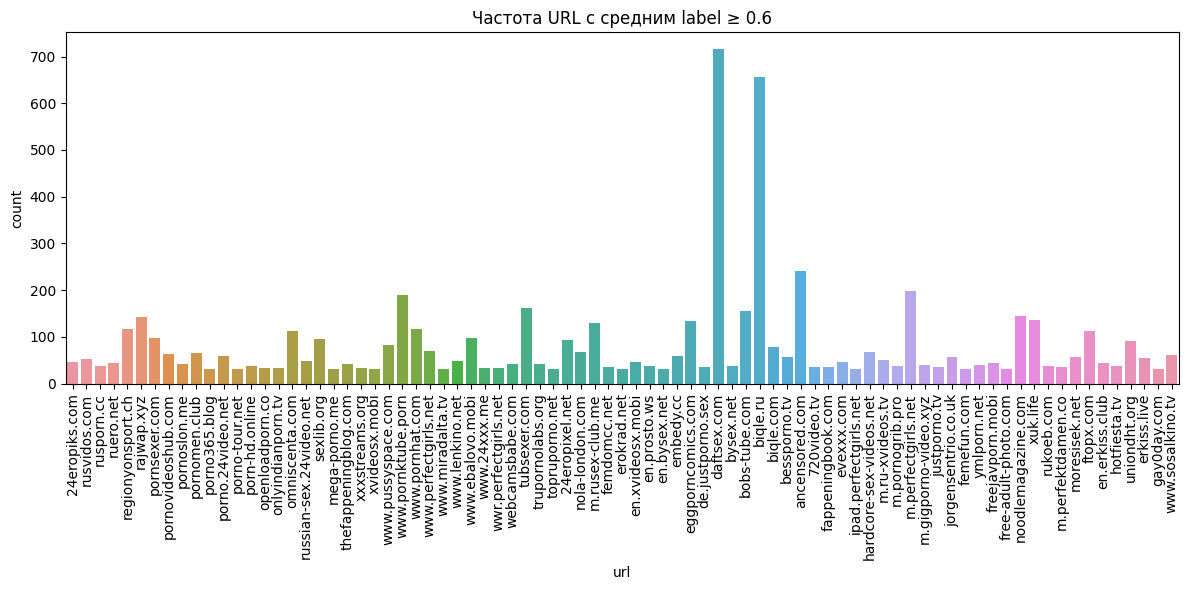

In [18]:
porn_sites = filtered_data.groupby('url')['label'].mean()[porn_percent >= PORN_THRESHOLD].sort_values(ascending=False).index
plot_data = filtered_data[filtered_data['url'].isin(porn_sites)]

plt.figure(figsize=(12, 6))
sns.countplot(data=plot_data, x='url', order=porn_sites)
plt.xticks(rotation=90)
plt.title('Частота URL с средним label ≥ 0.6')
plt.tight_layout()
plt.show()

In [19]:
data['is_porn_site'] = data['url'].isin(porn_sites).astype(int)

In [20]:
data['is_porn_site'].value_counts()

is_porn_site
0    122731
1      6571
Name: count, dtype: int64

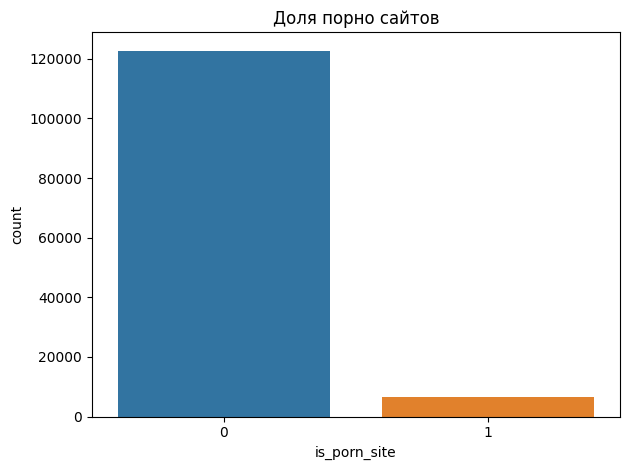

In [21]:
sns.countplot(data, x='is_porn_site')
plt.title('Доля порно сайтов')
plt.tight_layout()
plt.show()

In [22]:
# Target Encoding на 5 фолдах
N_FOLDS = 5
encoder = TargetEncoder()

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

for train_ind, test_ind in kfold.split(data, y=data['label']):
    X_train, y_train = data.loc[train_ind, 'url'], data.loc[train_ind, 'label']
    X_test, y_test = data.loc[test_ind, 'url'], data.loc[test_ind, 'label']

    encoder.fit(X_train, y_train)
    data.loc[test_ind, 'url_TE'] = encoder.transform(X_test).values

In [23]:
data['url_TE']

0         0.108635
1         0.103499
2         0.027112
3         0.126593
4         0.110123
            ...   
129297    0.017476
129298    0.023094
129299    0.099481
129300    0.126593
129301    0.105328
Name: url_TE, Length: 129302, dtype: float64

# Title

In [24]:
print(f"Колонка title содержит {data['title'].duplicated().sum()} дубликатов")

Колонка title содержит 0 дубликатов


In [25]:
# Удаляем стоп-слова и фильтруем символы
stopwords = nltk.corpus.stopwords.words('russian')

def filter_text(text, min_len=2):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'https?://\S+|www\.\S+','', text)
        text = re.sub(r'\d+', '', text)

        text = re.sub(r'[^\w\s]', '', text)
        for char in string.punctuation:
            text = text.replace(char, '')
        text = ' '.join([word for word in text.split() if word not in stopwords and len(word)>=min_len])
        return text
    return np.nan

In [26]:
data['title'] = data['title'].apply(lambda x : filter_text(x))

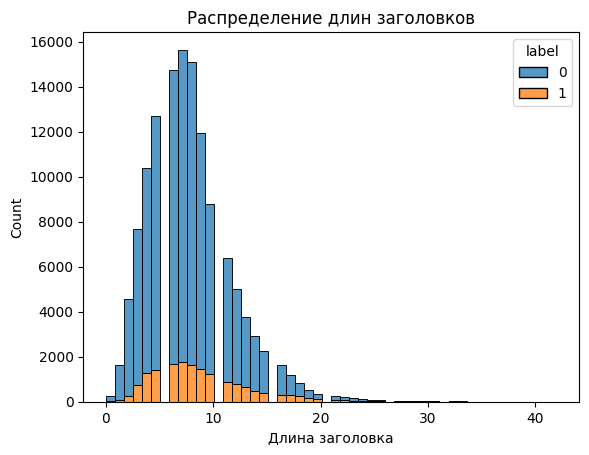

In [27]:
data['title_length'] = data['title'].apply(lambda x : len(x.split()))

sns.histplot(data=data, x='title_length', hue='label', multiple="stack", bins=50)
plt.xlabel('Длина заголовка')
plt.title('Распределение длин заголовков')
plt.show()

In [28]:
morph = pymorphy2.MorphAnalyzer()

def lemmatize_text(text):
    output = []
    for word in text.split():
        output.append(morph.parse(word)[0].normal_form)
    return ' '.join(output)
     
data['title'] = data['title'].apply(lambda text : lemmatize_text(text))

In [29]:
# Фильтрация редких слов
word_counter = Counter()
for text in data['title']:
    word_counter.update(text.split())
    
def filter_rare_words(text, min_count=50):
    return ' '.join([word for word in text.split() if word_counter[word]>=min_count])
    
data['title'] = data['title'].apply(lambda text : filter_rare_words(text))

# Модели

## Constant:

In [30]:
NFOLDS = 5
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True)

f1_scores = []
for _, test_ind in kfold.split(data, y=data['label']):
    y_val = data['label'].values
    f1_scores.append(f1_score(y_val, np.ones(len(y_val))))
    
print(f'Constant prediction F1-score : {np.mean(f1_scores)}')

Constant prediction F1-score : 0.22473930981458215


In [31]:
# Разделение на трейн и валидацию
X_train, X_val, y_train, y_val = train_test_split(
    data.drop('label', axis=1), 
    data['label'], 
    test_size=0.2, 
    shuffle=True, 
    random_state=42,
    stratify=data['label']
)

In [32]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
train_tf_idf_columns = tf_idf_vectorizer.fit_transform(X_train['title']).toarray()

val_tf_idf_columns = tf_idf_vectorizer.transform(X_val['title']).toarray()

train_tf_idf_data = pd.DataFrame(
    train_tf_idf_columns,
    columns=tf_idf_vectorizer.get_feature_names_out(),
    index=X_train.index
)

val_tf_idf_data = pd.DataFrame(
    val_tf_idf_columns,
    columns=tf_idf_vectorizer.get_feature_names_out(),
    index=X_val.index
)

In [33]:
# Для обучения финальной модели
big_test_tf_idf_columns = tf_idf_vectorizer.fit_transform(data['title']).toarray()

big_test_tf_idf_data = pd.DataFrame(
    big_test_tf_idf_columns,
    columns=tf_idf_vectorizer.get_feature_names_out(),
    index=data.index
)

In [34]:
big_test_tf_idf_data.head()

,adidas,adult,after,age,air,al,albums,alexis,all,am,...,яйцо,як,январь,яндекс,яой,яплакалъ,япония,японский,ярмарка,ярославль
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Multinomial Naive Bayes

In [35]:
naive_bayes = MultinomialNB()
naive_bayes.fit(train_tf_idf_data, y_train)
preds = naive_bayes.predict(val_tf_idf_data)
print(f'Naive Bayes F1-score : {f1_score(y_val, preds)}')

Naive Bayes F1-score : 0.9105326152004787


### Logistic Regression

In [36]:
train_tf_idf_data = pd.concat(
    [
        train_tf_idf_data, 
        X_train[['url_TE']]  
    ],
    axis=1
)

In [37]:
val_tf_idf_data = pd.concat(
    [
        val_tf_idf_data, 
        X_val[['url_TE']]  
    ],
    axis=1
)

big_test_tf_idf_data = pd.concat(
    [
        big_test_tf_idf_data,
        data[['url_TE']]
    ],
    axis=1
)

# Отнормируем данные для Logistic Regression

scaler = StandardScaler()

train_tf_idf_data = scaler.fit_transform(train_tf_idf_data)
val_tf_idf_data = scaler.transform(val_tf_idf_data)

big_test_tf_idf_data = scaler.fit_transform(big_test_tf_idf_data)

In [38]:
logreg = LogisticRegression(
    C = 0.1,
    solver = 'saga',
    class_weight = 'balanced',
)

logreg.fit(train_tf_idf_data, y_train)
preds = logreg.predict(val_tf_idf_data)

print(f'Logistic Regression F1-score : {f1_score(y_val, preds)}')

Logistic Regression F1-score : 0.9660684662946766


# Test data


In [39]:
test_data = pd.read_csv('/kaggle/input/ml-2025-spring-porn-detection/test.csv')
test_data.head()

,ID,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [40]:
test_data.isnull().sum()

ID       0
url      0
title    0
dtype: int64

In [41]:
test_data['title'].duplicated().sum()

7627

In [42]:
intersect_urls = data['url'].isin(test_data['url'].unique())
common_urls = data['url'][intersect_urls].unique()
print(f'У train и test {len(common_urls)} общих urls')

У train и test 16939 общих urls


# Embeddings

In [43]:
# Отформатируем данные
train_dataset = X_train['title'] +  ' ' + y_train.apply(lambda x: '__label__' + str(x))
val_dataset = X_val['title'] +  ' ' + y_val.apply(lambda x: '__label__' + str(x))

train_dataset.to_csv("train_fasttext.txt", header=None, index=None)
val_dataset.to_csv("val_fasttext.txt", header=None, index=None)

In [44]:
# Обучим модель
model = fasttext.train_supervised(
    input="train_fasttext.txt",
    minCount=5,  
    minn=2, maxn=5,  
    wordNgrams=2,  
    dim=25
) 
_, precision, recall = model.test('val_fasttext.txt')
print(f'FastText F1-score : {2 * precision * recall / (precision + recall)}')

FastText F1-score : 0.9849967131974788


# Final prediction

## Test data processing

In [45]:
test_data = pd.read_csv('/kaggle/input/ml-2025-spring-porn-detection/test.csv')

In [46]:
test_data_id = test_data['ID']

In [47]:
test_data

,ID,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67
...,...,...,...
165373,300682,etp.armtek.ru,Armtek - запчасти для грузовых и легковых авто...
165374,300683,mail.ru,"Лилия Якупова - Караганда, Карагандинская обла..."
165375,300684,xn----8sbnqchpeeeth.xn--p1ai,Администрация Лесного района Тверской области ...
165376,300685,www-sunhome-ru.cdn.ampproject.org,Сонник Изменение сознания. К чему снится Измен...


In [48]:
# Targeet Encoding URL
N_FOLDS = 5
encoder = TargetEncoder()

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

encoded_test_parts = []

for train_ind, val_ind in kfold.split(data, y=data['label']):
    encoder.fit(data.loc[train_ind, 'url'], data.loc[train_ind, 'label'])

    transformed = encoder.transform(test_data['url']).values
    encoded_test_parts.append(transformed)


test_data['url_TE'] = np.mean(encoded_test_parts, axis=0)

In [49]:
# Обработка текста
test_data['title'] = test_data['title'].apply(lambda x : filter_text(x))
test_data['title'] = test_data['title'].apply(lambda text : lemmatize_text(text))

In [50]:
word_counter = Counter()
for text in test_data['title']:
    word_counter.update(text.split())
    
def filter_rare_words(text, min_count=50):
    return ' '.join([word for word in text.split() if word_counter[word]>=min_count])
    
test_data['title'] = test_data['title'].apply(lambda text : filter_rare_words(text))

In [51]:
test_data

,ID,url,title,url_TE
0,135309,www.kommersant.ru,суд самара начать работа разный здание фото,0.097243
1,135310,urexpert.online,такой кто какой случай порядок правило процедура,0.103843
2,135311,imperimeha.ru,женщина империя мех part,0.126595
3,135312,national-porn.com,волосатый киска порно страна онлайн,0.217505
4,135313,2gis.ru,,0.009347
...,...,...,...,...
165373,300682,etp.armtek.ru,armtek запчасть грузовой легковой автомобиль о...,0.113418
165374,300683,mail.ru,лилия караганда область казахстан год мирmailru,0.017467
165375,300684,xn----8sbnqchpeeeth.xn--p1ai,администрация лесной район область снятие,0.113418
165376,300685,www-sunhome-ru.cdn.ampproject.org,сонник изменение что сниться изменение видеть ...,0.035283


In [52]:
test_tf_idf_columns = tf_idf_vectorizer.transform(test_data['title']).toarray()

test_tf_idf_data = pd.DataFrame(
    test_tf_idf_columns,
    columns=tf_idf_vectorizer.get_feature_names_out(),
    index=test_data.index
)

test_tf_idf_data = pd.concat(
    [
        test_tf_idf_data, 
        test_data[['url_TE']]  
    ],
    axis=1
)
test_tf_idf_data = scaler.transform(test_tf_idf_data)

## Logistic Regression prediction

In [53]:
logreg = LogisticRegression(
    C = 0.1,
    solver = 'saga',
    class_weight = 'balanced',
)

logreg.fit(big_test_tf_idf_data, data['label'])
preds = logreg.predict(test_tf_idf_data)

In [54]:
submission1 = pd.DataFrame({
    'ID': test_data_id,
    'label': preds
})

submission1.to_csv('submission1.csv', index=False)

## Final model - FastText

In [55]:
big_train_dataset = data['title'] +  ' ' + data['label'].apply(lambda x: '__label__' + str(x))
big_train_dataset.to_csv("big_train_fasttext.txt", header=None, index=None)

model = fasttext.train_supervised(
    input="big_train_fasttext.txt",
    minCount=5,  
    minn=2, maxn=5,  
    wordNgrams=2,  
    dim=25
) 

texts = test_data['title'].tolist()
labels, _ = model.predict(texts)
preds = [int(label[0].replace('__label__', '')) for label in labels]

In [56]:
submission2 = pd.DataFrame({
    'ID': test_data_id,
    'label': preds
})

submission2.to_csv('submission2.csv', index=False)